In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv("clothes_prediction.csv")

In [4]:
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


In [5]:
df.shape

(119734, 4)

In [6]:
df.isna().mean()*100

weight    0.000000
age       0.214642
height    0.275611
size      0.000000
dtype: float64

In [7]:
#as there are over 119k rows I decide to drop rows with NAs

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(119153, 4)

In [10]:
df.dtypes

weight      int64
age       float64
height    float64
size       object
dtype: object

In [11]:
df["size"].value_counts()

M       29575
S       21829
XXXL    21259
XL      19033
L       17481
XXS      9907
XXL        69
Name: size, dtype: int64

In [12]:
#there are 7 different sizes (it seems like the size XS is missing)
#I will treat the task as a multiclass classification problem

In [13]:
df.describe()

,weight,age,height
count,119153.000000,119153.000000,119153.000000
mean,61.756095,34.032714,165.807068
std,9.942877,8.148302,6.737797
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


In [14]:
#I perform some outliers detection...are there rows with strange values and strange pair/combinations of values?

In [15]:
df.loc[df.weight < 35]
#all these rows look suspicious to me..very low weight...mid heights and very big sizes..I will drop them

,weight,age,height,size
9986,22,46.0,152.40,XXXL
11986,31,37.0,175.26,XXXL
19379,22,29.0,167.64,L
69879,26,44.0,172.72,XXXL
85831,22,29.0,167.64,L
95165,22,29.0,167.64,XL


In [16]:
df = df.loc[df.weight >= 35]


In [17]:
df.loc[(df.height > 185) & (df["size"] == "S")]
#these rows still look likely

,weight,age,height,size
17406,63,38.0,185.42,S
92793,65,32.0,187.96,S
95008,63,38.0,185.42,S


In [18]:
df.loc[(df.weight > 75) & ((df["size"] == "S") | (df["size"] == "XXS")) ]
#these rows look suspicious to me...very high weight by small size... I will drop them

,weight,age,height,size
3922,95,31.0,162.56,S
11346,79,34.0,157.48,S
11400,83,28.0,162.56,S
12871,88,34.0,157.48,S
14380,102,53.0,160.02,XXS
18037,81,30.0,172.72,XXS
20984,79,41.0,165.10,S
26296,77,40.0,167.64,S
27712,79,47.0,167.64,S
40232,113,26.0,160.02,S


In [19]:
index_to_drop = df.loc[(df.weight > 75) & ((df["size"] == "S") | (df["size"] == "XXS")) ].index
df.drop(index= index_to_drop, inplace=True)

In [20]:
df.loc[(df.weight <70) & ((df["size"] == "XXXL") | (df["size"] == "XXL") | (df["size"] == "XL")) ]
#these combinations of weights, heights and sizes look suspicious to me...I will drop them

,weight,age,height,size
0,62,28.0,172.72,XL
10,63,30.0,170.18,XXXL
25,64,32.0,160.02,XL
28,58,31.0,154.94,XL
34,68,36.0,162.56,XL
...,...,...,...,...
119719,68,40.0,167.64,XL
119720,58,35.0,167.64,XXXL
119721,62,40.0,160.02,XXXL
119726,68,34.0,175.26,XL


In [21]:
index_to_drop_2 = df.loc[(df.weight <70) & ((df["size"] == "XXXL") | (df["size"] == "XXL") | (df["size"] == "XL")) ].index
df.drop(index= index_to_drop_2, inplace= True)

In [22]:
df.loc[(df.age < 5) & (df.weight >5)]
#this rows look also suspicious..I will drop them

,weight,age,height,size
1261,56,0.0,170.18,S
5553,65,3.0,175.26,L
7142,56,0.0,170.18,S
9103,81,2.0,177.80,XXXL
9146,56,0.0,165.10,M
12926,81,2.0,177.80,XXXL
22046,56,0.0,170.18,S
23593,77,0.0,177.80,XXXL
24858,49,4.0,165.10,S
26640,55,3.0,165.10,S


In [23]:
index_top_drop_3 = df.loc[(df.age < 10) & (df.weight >5)].index
df.drop(index= index_top_drop_3, inplace=True )

In [24]:
df.shape

(99380, 4)

In [25]:
#even if a dropped almost 20k rows I still have almost 100k observations which is enough

In [26]:
df["size"].value_counts()

M       29569
S       21802
L       17471
XXXL    16024
XXS      9900
XL       4595
XXL        19
Name: size, dtype: int64

## Weight

In [27]:
df.weight.describe()

count    99380.000000
mean        61.352526
std         10.696919
min         36.000000
25%         54.000000
50%         58.000000
75%         65.000000
max        136.000000
Name: weight, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weight', ylabel='Density'>

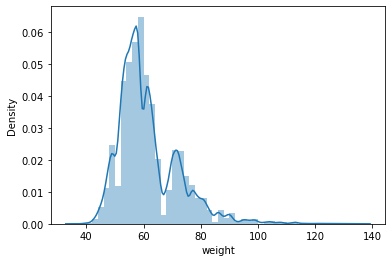

In [28]:
sns.distplot(df.weight)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weight', ylabel='Density'>

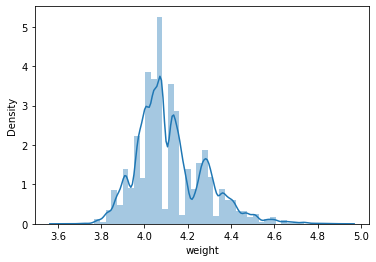

In [29]:
sns.distplot(np.log(df.weight+1))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weight', ylabel='Density'>

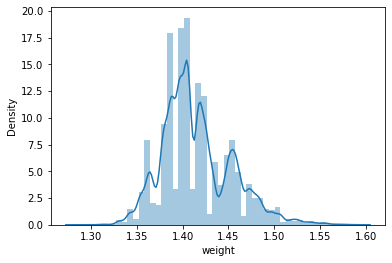

In [30]:
sns.distplot(np.log(np.log(df.weight+1)))

<AxesSubplot:xlabel='size', ylabel='weight'>

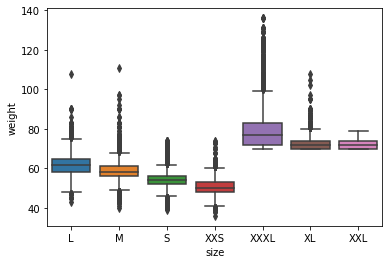

In [31]:
sns.boxplot(x = df["size"], y = df.weight)

The weight variable looks relevant. It seems that the weight increases moving from one size to the next which is something reasonable and expected

## Age

In [32]:
df.age.describe()

count    99380.000000
mean        33.597816
std          7.818400
min         14.000000
25%         29.000000
50%         32.000000
75%         37.000000
max        117.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='size', ylabel='age'>

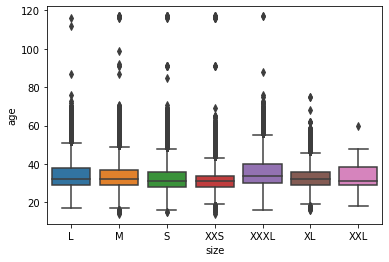

In [33]:
sns.boxplot(x = df["size"], y = df.age)

The age variable doesn't look really meaningful. There isn't a significant difference in the age based on the size.
I will probably discard this variable

## Height

In [34]:
df.height.describe()

count    99380.000000
mean       165.721505
std          6.802083
min        137.160000
25%        160.020000
50%        165.100000
75%        170.180000
max        193.040000
Name: height, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

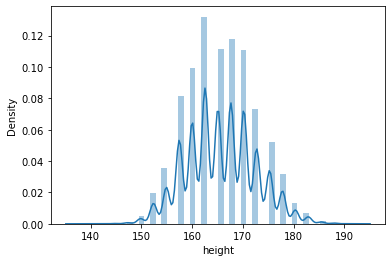

In [35]:
sns.distplot(df.height)

<AxesSubplot:xlabel='size', ylabel='height'>

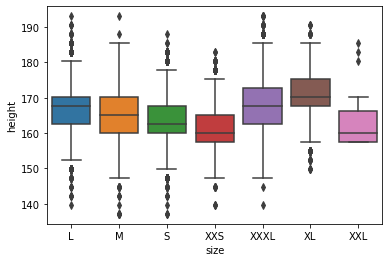

In [36]:
sns.boxplot(x = df["size"], y = df.height)

The variable height seems somehow relevant. Height seems to be connected to the size

In [37]:
df[["weight", "height"]].corr()
#as expected the variables height and weight are correlated
#I try to create a new variable for the BMI (BMI = weight/(height**2))

,weight,height
weight,1.000000,0.409927
height,0.409927,1.000000


In [38]:
df["bmi"] = df.weight/((df.height/100)**2)

In [39]:
df.bmi.describe()

count    99380.000000
mean        22.322077
std          3.559390
min         14.516158
25%         19.986154
50%         21.510247
75%         23.479664
max         54.323579
Name: bmi, dtype: float64

In [40]:
#the range of values is still realistic

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

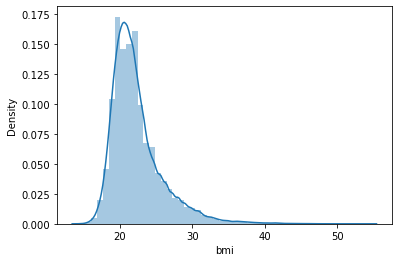

In [41]:
sns.distplot(df.bmi)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

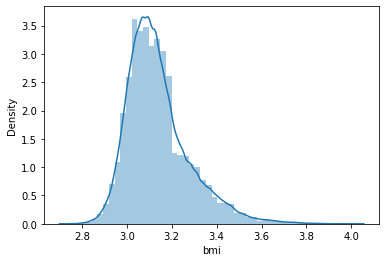

In [42]:
sns.distplot(np.log(df.bmi+1))

<AxesSubplot:xlabel='size', ylabel='bmi'>

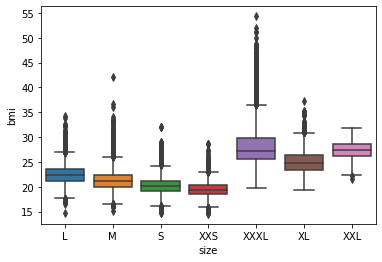

In [43]:
sns.boxplot(x = df["size"], y = df.bmi)

This new variable looks relevant...bmi differs based on the size. I will try to use it

In [44]:
#Before creating a model I want to apply PCA on height and weight and see if it can provide meaningful insights

I first scale height and weight...I use the log transformed variable for the weight

In [45]:
df["log_weight"] = np.log(df.weight)
df["log_bmi"] = np.log(df.bmi)

# PCA on log_weight and height

In [46]:
df_pca = df[["log_weight", "height"]]

In [47]:
#standardize the two features

In [48]:
scaler = StandardScaler() 
scaler.fit(df_pca)  
df_pca_scaled=pd.DataFrame(scaler.transform(df_pca))
df_pca_scaled.columns=df_pca.columns
df_pca_scaled.head()

,log_weight,height
0,-0.157366,0.282047
1,0.048897,-0.091370
2,0.441874,1.402297
3,0.149506,1.028880
4,-1.181455,-0.838204


In [49]:
#apply PCA

In [50]:
pca = PCA()
pca.fit(df_pca_scaled)
df_pca_scaled_PCA = pd.DataFrame(pca.transform(df_pca_scaled))
df_pca_scaled_PCA
df_pca_scaled_PCA.columns=['PC1','PC2']
df_pca_scaled_PCA

,PC1,PC2
0,0.088163,-0.310711
1,-0.030033,0.099184
2,1.304026,-0.679122
3,0.833245,-0.621812
4,-1.428114,-0.242715
...,...,...
99375,1.167294,-0.815854
99376,-2.417167,-0.175585
99377,0.762104,-0.692953
99378,1.079241,0.680367


In [51]:
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
explained_var

,0,1
0,0.719907,0.280093


In [52]:
pd.DataFrame(pca.components_,index=['PC1','PC2'],columns=df_pca.columns)

,log_weight,height
PC1,0.707107,0.707107
PC2,0.707107,-0.707107


In [53]:
#It seems that the first principal components captures people with high log-weight and height.
#The second principal component captures people with high log-weight but low height (it could be overweight/obest people)

## Classification Model with PCs

In [101]:
label_encoder = LabelEncoder()
df["labels_encoded"] = label_encoder.fit_transform(df["size"])

label_encoder.classes_

array(['L', 'M', 'S', 'XL', 'XXL', 'XXS', 'XXXL'], dtype=object)

In [102]:
X = df_pca_scaled_PCA[['PC1', 'PC2']]
y = df["labels_encoded"]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, stratify = y)

### Logistic Regression with PCs

In [104]:
logistic_PCA = LogisticRegression()
params_PCA = {"C": [0.1, 0.3, 0.4, 0.5, 0.6, 0.7,1], "multi_class": ['ovr'], "random_state": [123]}

In [107]:
grid_PCA = GridSearchCV(logistic_PCA, param_grid = params_PCA, cv = 5, scoring="accuracy", )

In [108]:
grid_PCA.fit(X_train, y_train, )

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 1],
                         'multi_class': ['ovr'], 'random_state': [123]},
             scoring='accuracy')

In [109]:
grid_PCA.best_params_

{'C': 0.4, 'multi_class': 'ovr', 'random_state': 123}

In [110]:
grid_PCA.best_score_

0.5202254120325488

In [111]:
y_pred = grid_PCA.predict(X_test)

In [112]:
accuracy_score(y_test, y_pred)

0.5189172871805192

Text(0.5, 1.0, 'Confusion Matrix')

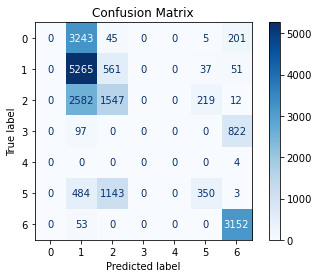

In [113]:
plot_confusion_matrix(grid_PCA, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

### Random Forest with PCs

In [70]:
random_PCA = RandomForestClassifier()
params_PCA_random = {"n_estimators": [50,60,70,80,90,100], "max_depth": [2,3,4], "random_state": [123]}

In [71]:
grid_PCA_random = GridSearchCV(random_PCA, param_grid = params_PCA_random, cv = 5, scoring="accuracy")

In [72]:
grid_PCA_random.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [50, 60, 70, 80, 90, 100],
                         'random_state': [123]},
             scoring='accuracy')

In [73]:
grid_PCA_random.best_params_

{'max_depth': 4, 'n_estimators': 70, 'random_state': 123}

In [74]:
grid_PCA_random.best_score_

0.5264137859293687

In [75]:
y_pred_random = grid_PCA_random.predict(X_test)

In [76]:
accuracy_score(y_test, y_pred_random)

0.5220366270879453

Text(0.5, 1.0, 'Confusion Matrix')

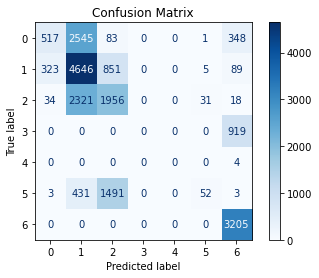

In [77]:
plot_confusion_matrix(grid_PCA_random, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

### SVC with PCs

In [72]:
#svc_PCA = SVC()
#params_PCA_svc = {"C": [0.1, 0.3, 0.6, 0.9, 1], "random_state": [123]}

In [73]:
#grid_PCA_svc = GridSearchCV(svc_PCA, param_grid = params_PCA_svc, cv = 5, scoring="accuracy")

In [74]:
#grid_PCA_svc.fit(X_train, y_train)

In [75]:
#grid_PCA_svc.best_params_

In [76]:
#grid_PCA_svc.best_score_

In [77]:
#y_pred_svc = grid_PCA_svc.predict(X_test)#

In [78]:
#accuracy_score(y_test, y_pred_svc)

In [79]:
#plot_confusion_matrix(grid_PCA_svc, X_test, y_test, cmap=plt.cm.Blues)
#plt.title("Confusion Matrix")

Interrupted due to computation problems

# Logistic Model with original variables

In [118]:
X = df[['log_weight', 'age', 'log_bmi']]
y = df["labels_encoded"]

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, stratify = y)

In [80]:
logistic = LogisticRegression()
params = {"logisticregression__C": [0.1, 0.3, 0.4, 0.5, 0.6, 0.7,1], "logisticregression__multi_class": ['ovr'], "logisticregression__random_state": [123]}

In [81]:
pipe = make_pipeline(StandardScaler(), logistic)

In [82]:
grid_logistic = GridSearchCV(pipe, param_grid = params, cv = 5, scoring="accuracy")

In [83]:
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7,
                                                   1],
                         'logisticregression__multi_class': ['ovr'],
                         'logisticregression__random_state': [123]},
             scoring='accuracy')

In [84]:
grid_logistic.best_params_

{'logisticregression__C': 1,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__random_state': 123}

In [85]:
grid_logistic.best_score_

0.5240239619437723

In [86]:
y_pred_logistic = grid_logistic.predict(X_test)

In [87]:
accuracy_score(y_test, y_pred_logistic)

0.5232441135037231

Text(0.5, 1.0, 'Confusion Matrix')

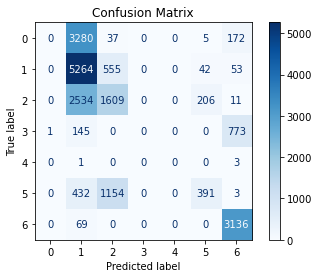

In [88]:
plot_confusion_matrix(grid_logistic, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

In [89]:
#slight improvement using the orginal variables + newly created features (bmi)

# Random Forest with original variables

In [90]:
random = RandomForestClassifier()
params_random = {"randomforestclassifier__n_estimators": [50,60,70,80,90,100], "randomforestclassifier__max_depth": [2,3,4], "randomforestclassifier__random_state": [123]}

In [91]:
pipe_random = make_pipeline(StandardScaler(), random)

In [92]:
grid_random = GridSearchCV(pipe_random, param_grid = params_random, cv = 5, scoring="accuracy")

In [93]:
grid_random.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4],
                         'randomforestclassifier__n_estimators': [50, 60, 70,
                                                                  80, 90, 100],
                         'randomforestclassifier__random_state': [123]},
             scoring='accuracy')

In [94]:
grid_random.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__random_state': 123}

In [95]:
grid_random.best_score_

0.5487397303836355

In [96]:
y_pred_random = grid_random.predict(X_test)

In [97]:
accuracy_score(y_test, y_pred_random)

0.5477963372912055

Text(0.5, 1.0, 'Confusion Matrix')

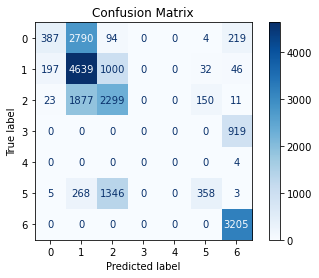

In [98]:
plot_confusion_matrix(grid_random, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

In [99]:
#significant improvement with the random forest and original variables + newly created variable (bmi)

In [100]:
classification_report(y_test, y_pred_random)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.63      0.11      0.19      3494\n           1       0.48      0.78      0.60      5914\n           2       0.49      0.53      0.51      4360\n           3       0.00      0.00      0.00       919\n           4       0.00      0.00      0.00         4\n           5       0.66      0.18      0.28      1980\n           6       0.73      1.00      0.84      3205\n\n    accuracy                           0.55     19876\n   macro avg       0.43      0.37      0.35     19876\nweighted avg       0.54      0.55      0.49     19876\n'

# KNN with original variables

In [134]:
knn = KNeighborsClassifier()
params_knn = {"kneighborsclassifier__n_neighbors": [3,5,7,10,13], "kneighborsclassifier__weights": ['uniform', 'distance'], "kneighborsclassifier__p": [1, 2]}

In [135]:
pipe_knn = make_pipeline(StandardScaler(), knn)

In [136]:
grid_knn = GridSearchCV(pipe_knn, param_grid = params_knn, cv = 5, scoring="accuracy")

In [137]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 13],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [138]:
grid_knn.best_params_

{'kneighborsclassifier__n_neighbors': 13,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [139]:
grid_knn.best_score_

0.5668520551098603

In [140]:
y_pred_knn = grid_knn.predict(X_test)

In [141]:
accuracy_score(y_test, y_pred_knn)

0.5707385791909841

Text(0.5, 1.0, 'Confusion Matrix')

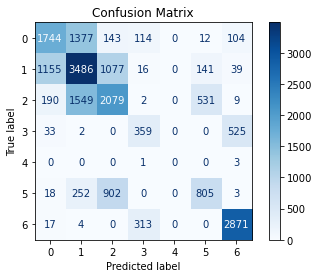

In [142]:
plot_confusion_matrix(grid_knn, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

In [143]:
#knn with original variables + newly created variable (bmi) seems to be the best one

In [144]:
classification_report(y_test, y_pred_knn)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.55      0.50      0.52      3494\n           1       0.52      0.59      0.55      5914\n           2       0.49      0.48      0.49      4360\n           3       0.45      0.39      0.42       919\n           4       0.00      0.00      0.00         4\n           5       0.54      0.41      0.46      1980\n           6       0.81      0.90      0.85      3205\n\n    accuracy                           0.57     19876\n   macro avg       0.48      0.47      0.47     19876\nweighted avg       0.57      0.57      0.57     19876\n'

In [147]:
# weighted average precision = 0.57
# weighted average recall = 0.57

#with random forest I previosuly obtained 0.54 and 0.55 respectively

#KNN seems to be better under all aspects: accuracy, precision and recall